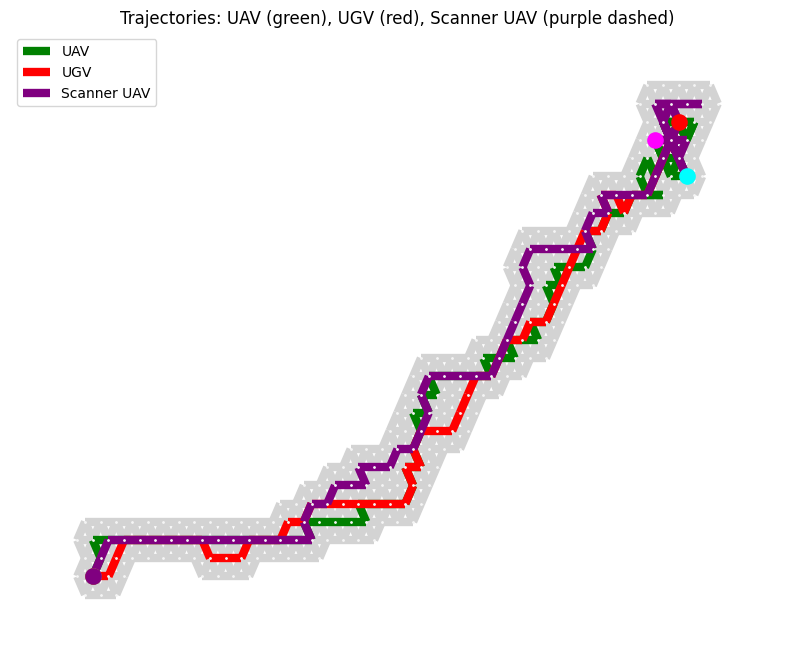

In [ ]:
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict

def compute_hex_pos(G, hex_size=1):
    # … your unchanged function …
    pos = {}
    for node in G.nodes():
        if node.startswith("(") and node.endswith(")"):
            try:
                q, r = map(int, node[1:-1].split(","))
                x = hex_size * np.sqrt(3) * (q + r / 2)
                y = hex_size * (3/2) * r
                pos[node] = (x, y)
            except:
                pos[node] = None
        else:
            pos[node] = None
    missing = [n for n,p in pos.items() if p is None]
    if missing:
        spring = nx.spring_layout(G, seed=42)
        for n in missing:
            pos[n] = spring[n]
    return pos

# --- 1) Load the base graph from JSON (unchanged) ---
with open("config/network_test_two.json") as f:
    data = json.load(f)
G = nx.Graph()
for e in data["edges"]:
    u,v = e["from"], e["to"]
    attrs = {**e.get("metadata", {}), **{k:v for k,v in e.items() if k not in ("from","to","metadata")}}
    G.add_edge(u, v, **attrs)

# --- 2) Read your CSV with the recorded steps ---

df = pd.read_csv("results/2025-04-29_16-11/saves/out_1280000.csv")#"results/baselines/baseline_out.csv")#
#1955840
#1720320
#1710080
#1884160
#1474560
#1280000
#  Use OrderedDict keys as an "ordered set"
uav_nodes   = OrderedDict()
ugv_nodes   = OrderedDict()
scan_nodes  = OrderedDict()
uav_path    = []
ugv_path    = []
scan_path   = []

for _, row in df.iterrows():
    # grab exactly the new column names
    su = str(row["start_uav"])
    eu = str(row["end_uav"])
    sg = str(row["start_ugv"])
    eg = str(row["end_ugv"])
    # if your CSV has scanner columns:
    ss = str(row["start_scanner"]) if "start_scanner" in row else None
    es = str(row["end_scanner"])   if "end_scanner"   in row else None

    # 1) record nodes in insertion order
    uav_nodes[su] = None
    uav_nodes[eu] = None
    ugv_nodes[sg] = None
    ugv_nodes[eg] = None

    if ss and es and ss != "nan" and es != "nan":
        scan_nodes[ss] = None
        scan_nodes[es] = None

    # 2) record the actual traversed edges
    uav_path.append((su, eu))
    ugv_path.append((sg, eg))
    if ss and es and ss != "nan" and es != "nan":
        scan_path.append((ss, es))

# Convert back to lists (ordered!)
uav_nodes  = list(uav_nodes.keys())
ugv_nodes  = list(ugv_nodes.keys())
scan_nodes = list(scan_nodes.keys())

# --- 3) Gather one‐hop neighbors around any visited node ---
neighbors = set()
for n in uav_nodes + ugv_nodes + scan_nodes:
    if n in G:
        neighbors |= set(G.neighbors(n))

# --- 4) Build the subgraph ---
relevant = set(uav_nodes + ugv_nodes + scan_nodes) | neighbors
H = G.subgraph(relevant).copy()

# --- 5) Filter path edges so they actually lie in H ---
def keep_in_subgraph(path_edges):
    return [(u,v) for u,v in path_edges
            if H.has_edge(u,v) or H.has_edge(v,u)]

uav_path    = keep_in_subgraph(uav_path)
ugv_path    = keep_in_subgraph(ugv_path)
scan_path   = keep_in_subgraph(scan_path)

# --- 6) Position everything on the hex grid (with spring fallback) ---
pos = compute_hex_pos(H, hex_size=2)

# --- 7) Draw ---
plt.figure(figsize=(10,8))

# base network
nx.draw_networkx_edges(H, pos, edge_color="lightgray", width=6)
nx.draw_networkx_nodes( H, pos, node_size=1, node_color="whitesmoke")

# highlight start/end for each agent
if uav_nodes:
    nx.draw_networkx_nodes(H, pos,
        nodelist=[uav_nodes[0]],   node_color="blue",   node_size=120)  # UAV start
    nx.draw_networkx_nodes(H, pos,
        nodelist=[uav_nodes[-1]],  node_color="cyan",   node_size=120)  # UAV end
if ugv_nodes:
    nx.draw_networkx_nodes(H, pos,
        nodelist=[ugv_nodes[0]],   node_color="orange", node_size=120)  # UGV start
    nx.draw_networkx_nodes(H, pos,
        nodelist=[ugv_nodes[-1]],  node_color="red",    node_size=120)  # UGV end
if scan_nodes:
    nx.draw_networkx_nodes(H, pos,
        nodelist=[scan_nodes[0]],  node_color="purple",  node_size=120)  # Scanner start
    nx.draw_networkx_nodes(H, pos,
        nodelist=[scan_nodes[-1]], node_color="magenta", node_size=120)  # Scanner end

# overlay each path
if uav_path:
    nx.draw_networkx_edges(H, pos, edgelist=uav_path,  edge_color="green",   width=6, label="UAV")
if ugv_path:
    nx.draw_networkx_edges(H, pos, edgelist=ugv_path,  edge_color="red",     width=6, label="UGV")
if scan_path:
    nx.draw_networkx_edges(H, pos, edgelist=scan_path,
        edge_color="purple", style="dashed", width=6, label="Scanner UAV")

plt.legend(loc="upper left")
plt.title("Trajectories: UAV (green), UGV (red), Scanner UAV (purple dashed)")
plt.axis("off")
plt.show()
